In [1]:
%matplotlib widget

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner

In [3]:
data = np.loadtxt('./Kepler/spec_001723700.txt')
f = data[:, 0] # frequency in microHz
psd = data[:, 1] # power spectral density in ppm^2/microHz

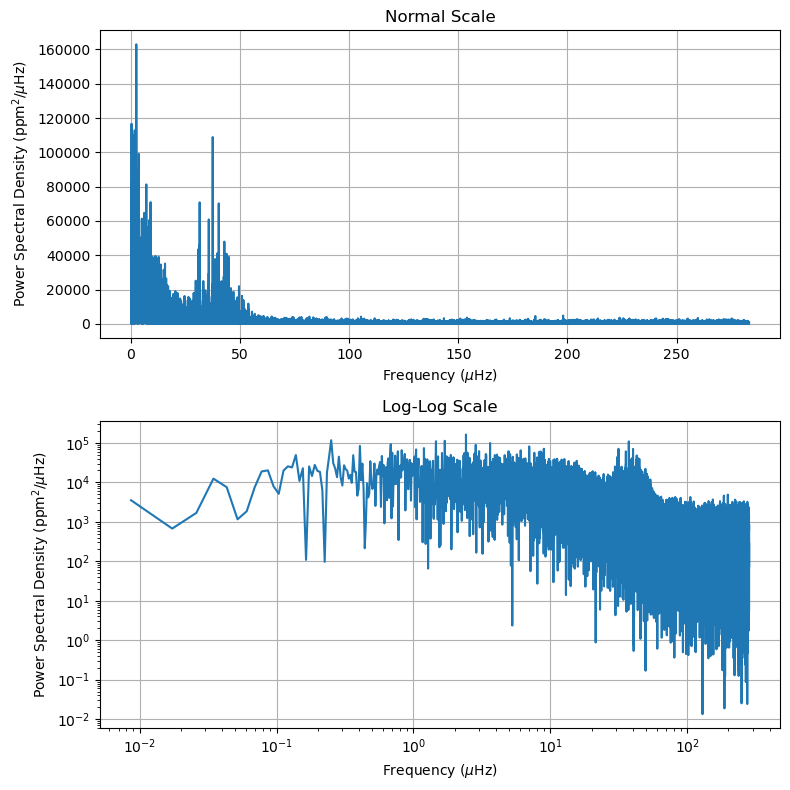

In [16]:
# plot the data both in normal scale and loglog scale
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].plot(f, psd)
ax[0].set_xlabel('Frequency ($\mu$Hz)')
ax[0].set_ylabel('Power Spectral Density (ppm$^2/\mu$Hz)')
ax[0].set_title('Normal Scale')
ax[0].grid()

ax[1].loglog(f, psd)
ax[1].set_xlabel('Frequency ($\mu$Hz)')
ax[1].set_ylabel('Power Spectral Density (ppm$^2/\mu$Hz)')
ax[1].set_title('Log-Log Scale')
ax[1].grid()

plt.tight_layout()

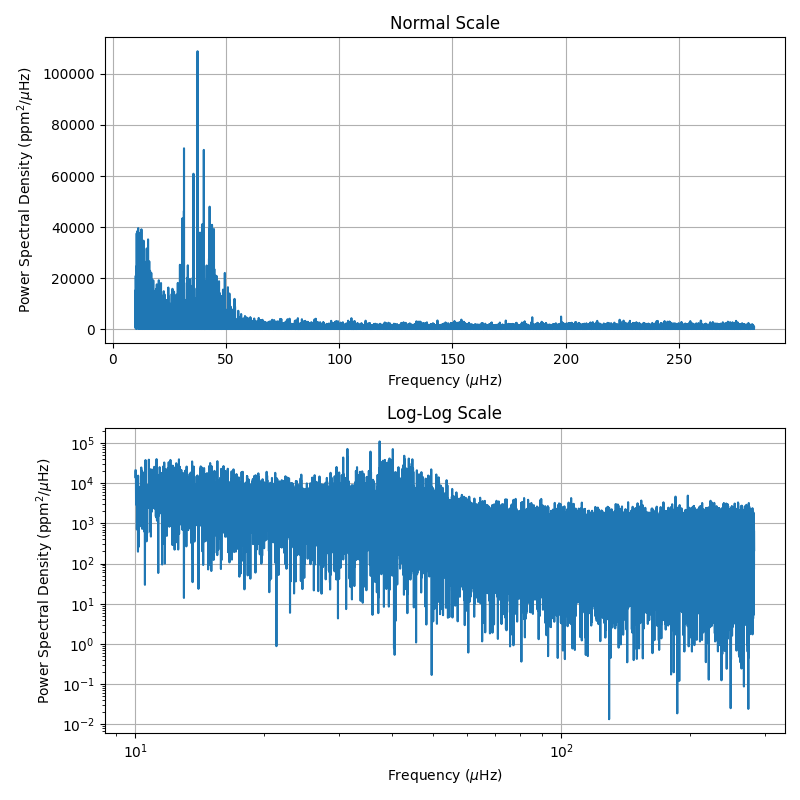

In [5]:
f_cut = f[(f > 10)]
psd_cut = psd[(f > 10)]

fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].plot(f_cut, psd_cut)
ax[0].set_xlabel('Frequency ($\mu$Hz)')
ax[0].set_ylabel('Power Spectral Density (ppm$^2/\mu$Hz)')
ax[0].set_title('Normal Scale')
ax[0].grid()

ax[1].loglog(f_cut, psd_cut)
ax[1].set_xlabel('Frequency ($\mu$Hz)')
ax[1].set_ylabel('Power Spectral Density (ppm$^2/\mu$Hz)')
ax[1].set_title('Log-Log Scale')
ax[1].grid()

plt.tight_layout()

In [6]:
# Define the global oscillation spectrum model
def global_oscillation_spectrum(frequency, B, numax, beta, c, a, sigma):
    mean_background = B * (frequency / numax)**(beta)  # Power-law background
    photon_noise = c                                  # Photon noise
    gaussian_envelope = a * np.exp(-0.5 * ((frequency - numax) / sigma)**2)  # Oscillation envelope
    return mean_background + photon_noise + gaussian_envelope

# Define the log-likelihood function
def log_likelihood(theta, frequency, psd):
    B, numax, beta, c, a, sigma = theta
    model = global_oscillation_spectrum(frequency, B, numax, beta, c, a, sigma)
    if np.any(model <= 0):
        return -np.inf  # Avoid invalid model values
    return -np.sum(np.log(model) + psd / model)

# Define the log-prior function
def log_prior(theta):
    B, numax, beta, c, a, sigma = theta
    if 1e3 < B < 2e3 and 35 < numax < 45 and -2 < beta < -1 and 1e2 < c < 1e3 and 1e3 < a < 5e4 and 0 < sigma < 10:
        return 0.0  # Uniform priors in these ranges
    return -np.inf  # Invalid parameter set

# Define the log-probability function
def log_probability(theta, frequency, power_density):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, frequency, power_density)

# Prepare data
# f_cut = f[(f > 10) & (f<120)]  # Limit frequency range
# psd_cut = psd[(f > 10) & (f<120)]  # Limit frequency range

f_cut = f[(f > 10)]
psd_cut = psd[(f > 10)]

# f_cut = f
# psd_cut = psd

# Set initial guesses for the parameters
initial_guess = np.array([1.5e3, 40, -1.5, 5e2, 1e4, 5])  # Background, numax, beta, photon noise, amplitude, sigma

# Initialize MCMC
nwalkers = 32
ndim = len(initial_guess)
pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim) * initial_guess

# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(f_cut, psd_cut))

# Run the MCMC
nburn = 1000
nprod = 1000
sampler.run_mcmc(pos, nburn + nprod, progress=True)
samples = sampler.get_chain(discard=nburn, flat=True)

100%|██████████| 2000/2000 [00:28<00:00, 70.65it/s]


In [17]:
# Analyze the results
best_fit = np.median(samples, axis=0)
B, numax, beta, c, a, sigma = best_fit  # Extract best-fit parameters

# Generate the best-fit model
best_fit_model = global_oscillation_spectrum(f_cut, B, numax, beta, c, a, sigma)

# Gaussian envelope
gaussian_envelope = a * np.exp(-0.5 * ((f_cut - numax) / sigma)**2)
# Photon noise
photon_noise = c
# Power-law background
mean_background = B * (f_cut / numax)**(beta)

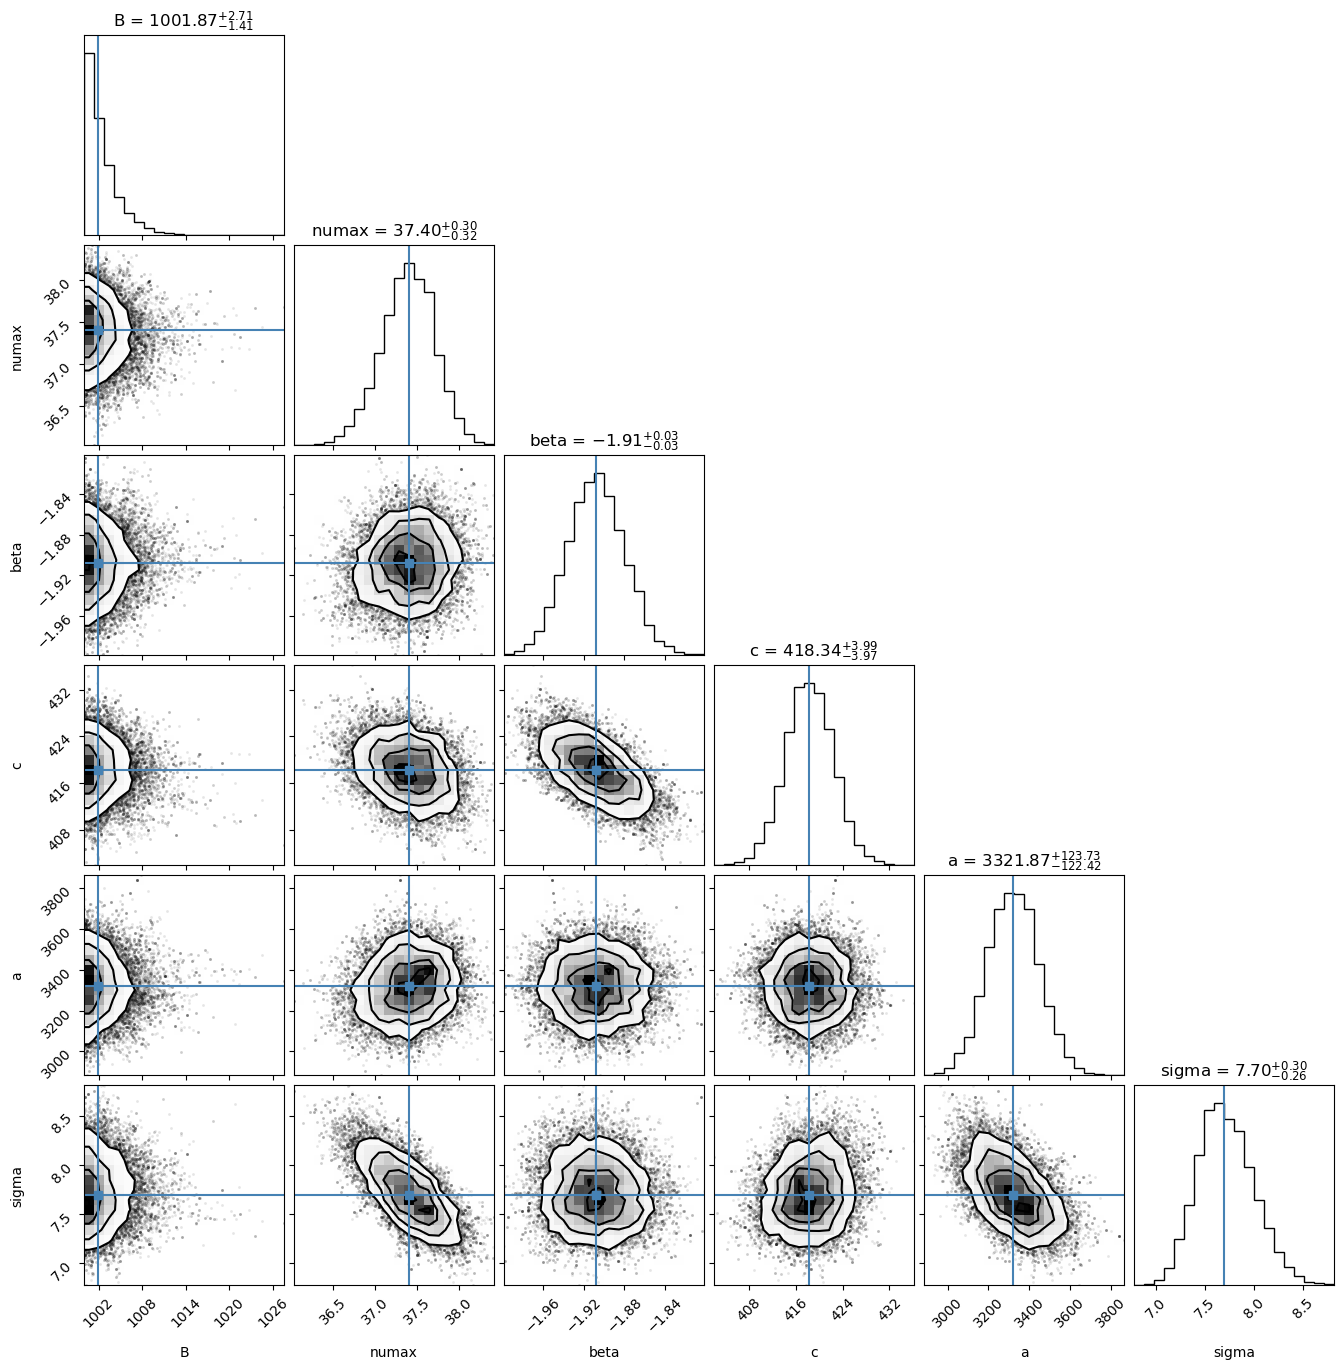

In [18]:
labels = ["B", "numax", "beta", "c", "a", "sigma"]
fig = corner.corner(samples, labels=labels, truths=best_fit, show_titles=True)

In [19]:
# Print the best-fit parameters
print("Best-fit parameters:")
# print(f"Background: {B:.2f}")
print(f"Numax: {numax:.2f}")
print(f"Beta: {beta:.2f}")
print(f"Photon Noise: {c:.2f}")
print(f"Amplitude: {a:.2f}")
print(f"Sigma: {sigma:.2f}")

Best-fit parameters:
Numax: 37.40
Beta: -1.91
Photon Noise: 418.34
Amplitude: 3321.87
Sigma: 7.70


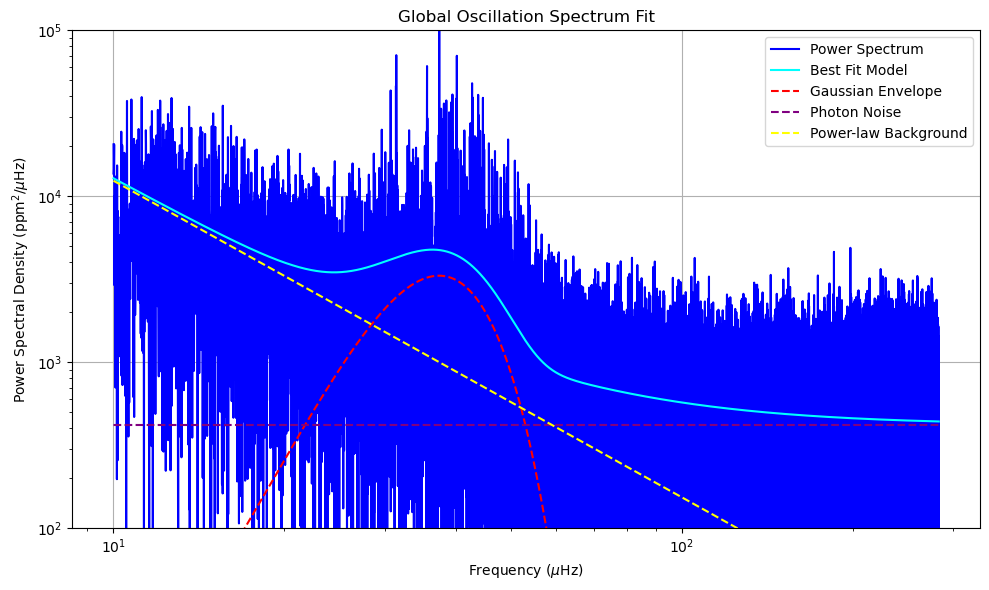

In [20]:
# Plot all the components in a single plot
plt.figure(figsize=(10, 6))
plt.loglog(f_cut, psd_cut, label="Power Spectrum", color="blue")
plt.loglog(f_cut, best_fit_model, label="Best Fit Model", color="cyan")
plt.loglog(f_cut, gaussian_envelope, label="Gaussian Envelope", linestyle="--", color="red")
plt.loglog(f_cut, photon_noise * np.ones_like(f_cut), label="Photon Noise", linestyle="--", color="purple")
plt.loglog(f_cut, mean_background, label="Power-law Background", linestyle="--", color="yellow")
plt.xlabel("Frequency ($\mu$Hz)")
plt.ylabel("Power Spectral Density (ppm$^2/\mu$Hz)")
plt.title("Global Oscillation Spectrum Fit")
plt.ylim(1e2, 1e5)
plt.legend()
plt.grid()
plt.tight_layout()


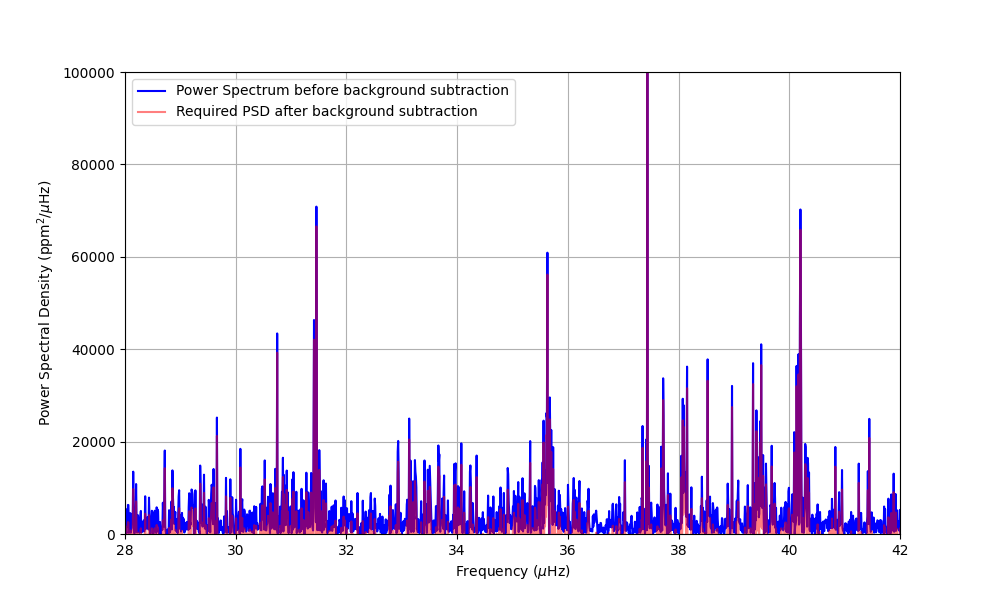

In [11]:
# subtract the best-fit model from the data
new_psd = psd_cut - best_fit_model

# plot before background subtraction and after background subtraction in the same plot
plt.figure(figsize=(10, 6))
plt.plot(f_cut, psd_cut, label="Power Spectrum before background subtraction", color="blue")
plt.plot(f_cut, new_psd, label="Required PSD after background subtraction", color="red", alpha = 0.5)
plt.xlabel("Frequency ($\mu$Hz)")
plt.ylabel("Power Spectral Density (ppm$^2/\mu$Hz)")
plt.xlim(28, 42)
plt.ylim(0, 1e5)
plt.legend()
plt.grid()


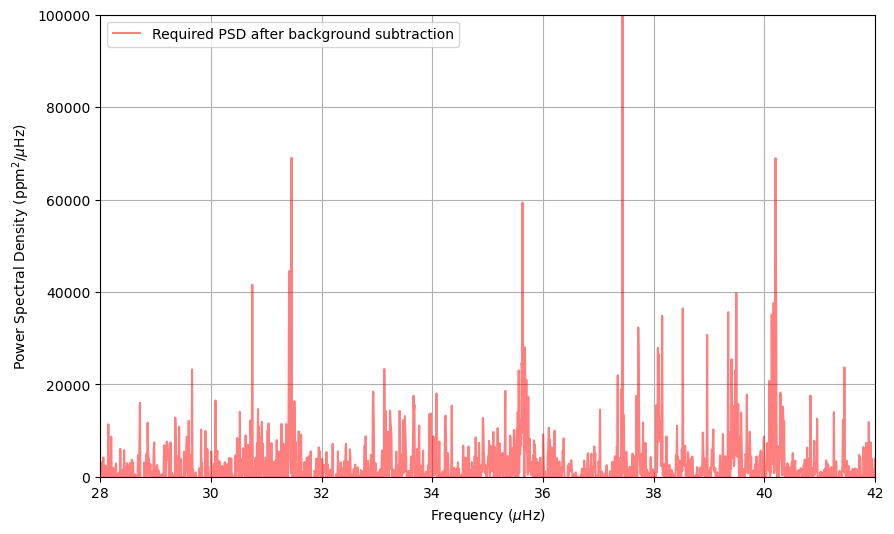

In [21]:
required_psd = psd_cut - mean_background - photon_noise

# plot before background subtraction and after background subtraction in the same plot
plt.figure(figsize=(10, 6))
# plt.plot(f_cut, psd_cut, label="Power Spectrum before background subtraction", color="blue")
plt.plot(f_cut, required_psd, label="Required PSD after background subtraction", color="red", alpha = 0.5)
plt.xlabel("Frequency ($\mu$Hz)")
plt.ylabel("Power Spectral Density (ppm$^2/\mu$Hz)")
plt.xlim(28, 42)
plt.ylim(0, 1e5)
plt.legend()
plt.grid()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import emcee

Delta_nu = 4.483
alpha = 0.0098
epsilon = 0.961
numax = 39.23

def lorentzian(frequency, H, nu_center, Gamma):
    return H / (1 + 4 * ((frequency - nu_center) / Gamma)**2)

def lorentzian_sum(frequency, H1, Gamma1, H2, Gamma2, d02):
    # Calculate nu_center using the full asymptotic formula for l=0 and l=2
    n_max = numax / Delta_nu - epsilon
    # n_radial_l0 = n_radial + 1
    nu_center1 = ((n_radial + 1 + 0 / 2 + epsilon + 0 + alpha / 2 * (n_radial + 1 - n_max)**2) * Delta_nu)  # l=0
    nu_center2 = ((n_radial + 2 / 2 + epsilon + d02 + alpha / 2 * (n_radial - n_max)**2) * Delta_nu)  # l=2
    return (lorentzian(frequency, H1, nu_center1, Gamma1) +
            lorentzian(frequency, H2, nu_center2, Gamma2))


# def lorentzian_sum(frequency, H1, nu_center1, Gamma1, H2, nu_center2, Gamma2):
#     return (lorentzian(frequency, H1, nu_center1, Gamma1) +
#             lorentzian(frequency, H2, nu_center2, Gamma2)) 

# def log_likelihood(theta, frequency, power_density):
#     H1, Gamma1, H2, Gamma2, Delta_nu, epsilon, alpha = theta
#     model = lorentzian_sum(frequency, H1, Gamma1, H2, Gamma2, Delta_nu, epsilon, alpha)
#     return -np.sum(np.log(model) + power_density / model)

def log_likelihood(theta, frequency, power_density):
    H1, Gamma1, H2, Gamma2, d02 = theta
    model = lorentzian_sum(frequency, H1, Gamma1, H2, Gamma2, d02)
    return -np.sum(np.log(model) + power_density / model)
# def log_likelihood(theta, frequency, power_density):
#     H1, nu_center1, Gamma1, H2, nu_center2, Gamma2 = theta
#     model = lorentzian_sum(frequency, H1, nu_center1, Gamma1, H2, nu_center2, Gamma2)
#     return -np.sum(np.log(model) + power_density / model)

# def log_prior(theta):
#     H1, Gamma1, H2, Gamma2, Delta_nu, epsilon, alpha = theta
#     if 2e4 < H1 < 5e4 and 0.01 < Gamma1 < 1 and \
#        1e4 < H2 < 3e4 and 0.01 < Gamma2 < 1 and \
#         3 < Delta_nu < 6 and 0.01 < epsilon < 1.0 and \
#        0 < alpha < 1:
#         return 0.0  # Uniform priors in these ranges
#     return -np.inf  # Invalid parameter set

def log_prior(theta):
    H1, Gamma1, H2, Gamma2, d02 = theta
    if 2e4 < H1 < 5e4 and 0.01 < Gamma1 < 0.5 and \
       1e4 < H2 < 3e4 and 0.01 < Gamma2 < 0.5 and \
        -1.0 < d02 < -0.01:
        return 0.0  # Uniform priors in these ranges
    return -np.inf  # Invalid parameter set

# def log_prior(theta):
#     H1, nu_center1, Gamma1, H2, nu_center2, Gamma2 = theta
#     if 2e4 < H1 < 5e4 and 39.75 < nu_center1 < 40.5 and 0.01 < Gamma1 < 1 and \
#        1e4 < H2 < 3e4 and 39 < nu_center2 < 40 and 0.01 < Gamma2 < 1:
#         return 0.0  # Uniform priors in these ranges
#     return -np.inf  # Invalid parameter set

def log_probability(theta, frequency, power_density):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, frequency, power_density)

# Subset data around the peak
frequency_peak = f[(f > 39) & (f < 41)]
power_density_peak = required_psd[(f_cut > 39) & (f_cut < 41)]

# Initial guesses for parameters
n_radial = 7
# initial_guess = np.array([4e4, 0.25, 2e4, 0.25, 5, 0.98, 0.01])  # H1, Gamma1, H2, Gamma2, Delta_nu, epsilon, alpha
initial_guess = np.array([4e4, 0.25, 2e4, 0.25, -0.1])  # H1, Gamma1, H2, Gamma2, epsilon
# initial_guess = [4e4, 40, 0.05, 2e4, 39.5, 0.05]  # H1, nu_center1, Gamma1, H2, nu_center2, Gamma2
ndim = len(initial_guess)
nwalkers = 50

# Initialize walkers around the initial guess
np.random.seed(42)
pos = initial_guess + 1e-2 * np.random.randn(nwalkers, ndim) * initial_guess
# print(pos)

# Set up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(frequency_peak, power_density_peak))


# Run the MCMC
nburn = 10000
nprod = 5000
sampler.run_mcmc(pos, nburn + nprod, progress=True)
samples = sampler.get_chain(discard=nburn, flat=True)

# Get the samples
# samples = sampler.get_chain(discard=nburn+2000, flat=True)

# Compute best-fit parameters (median of the posterior)
# best_params = np.median(samples, axis=0)
# H1, nu_center1, Gamma1, H2, nu_center2, Gamma2 = best_params
# print(f"Best-fit parameters:")
# print(f"Radial mode (l=0): H={H1:.2f}, nu_center={nu_center1:.2f}, Gamma={Gamma1:.2f}")
# print(f"Quadrupole mode (l=2): H={H2:.2f}, nu_center={nu_center2:.2f}, Gamma={Gamma2:.2f}")

# samples = sampler.get_chain(discard=nburn+2000, flat=True)

# Compute best-fit parameters (median of the posterior)
# best_params = np.median(samples, axis=0)
# H1, Gamma1, H2, Gamma2, Delta_nu, epsilon, alpha = best_params
# n_max = numax / Delta_nu - epsilon
# nu_center1 = ((n_radial_1 + 0 / 2 + epsilon + 0 + alpha / 2 * (n_radial_1 - n_max)**2) * Delta_nu)
# nu_center2 = ((n_radial + 2 / 2 + epsilon -0.12 + alpha / 2 * (n_radial - n_max)**2) * Delta_nu)
# print(f"Best-fit parameters:")
# print(f"Radial mode (l=0): H={H1:.2f}, nu_center={nu_center1:.2f}, Gamma={Gamma1:.2f}")
# print(f"Quadrupole mode (l=2): H={H2:.2f}, nu_center={nu_center2:.2f}, Gamma={Gamma2:.2f}")
# print(f"Fitted Delta_nu={Delta_nu:.2f}, epsilon={epsilon:.2f}, alpha={alpha:.2f}, n_max={n_max:.2f}")

samples = sampler.get_chain(discard=nburn+2000, flat=True)
best_params = np.median(samples, axis=0)
H1, Gamma1, H2, Gamma2, d02 = best_params
print(f"Best-fit parameters:")
print(f"Radial mode (l=0): H={H1:.2f}, Gamma={Gamma1:.2f}")
print(f"Quadrupole mode (l=2): H={H2:.2f}, Gamma={Gamma2:.2f}")
# print(f"Fitted epsilon={epsilon:.2f}")
print(f"Fitted d02={d02:.2f}")
n_max = numax / Delta_nu - epsilon
nu_center1 = ((n_radial + 1 + 0 / 2 + epsilon + 0 + alpha / 2 * (n_radial + 1 - n_max)**2) * Delta_nu)
nu_center2 = ((n_radial + 2 / 2 + epsilon + d02 + alpha / 2 * (n_radial - n_max)**2) * Delta_nu)
print(f"nu_center1={nu_center1:.2f}, nu_center2={nu_center2:.2f}")

100%|██████████| 15000/15000 [00:10<00:00, 1481.01it/s]

Best-fit parameters:
Radial mode (l=0): H=21054.57, Gamma=0.27
Quadrupole mode (l=2): H=11650.72, Gamma=0.21
Fitted d02=-0.16
nu_center1=40.17, nu_center2=39.45


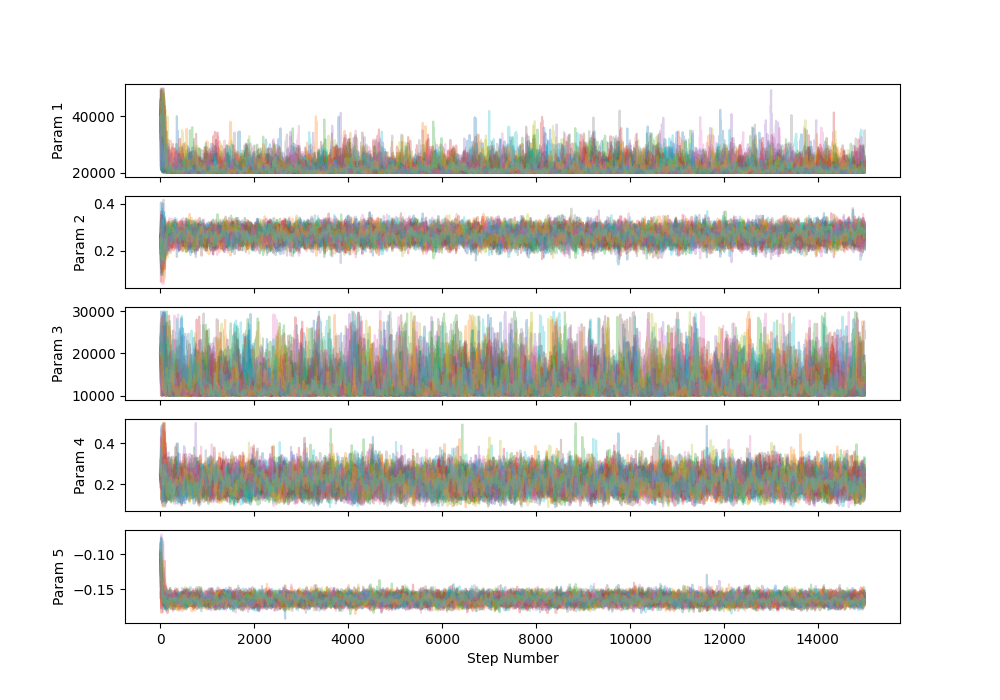

In [14]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
for i in range(ndim):
    axes[i].plot(sampler.get_chain()[:, :, i], alpha=0.3)
    axes[i].set_ylabel(f"Param {i+1}")
axes[-1].set_xlabel("Step Number")
plt.show()

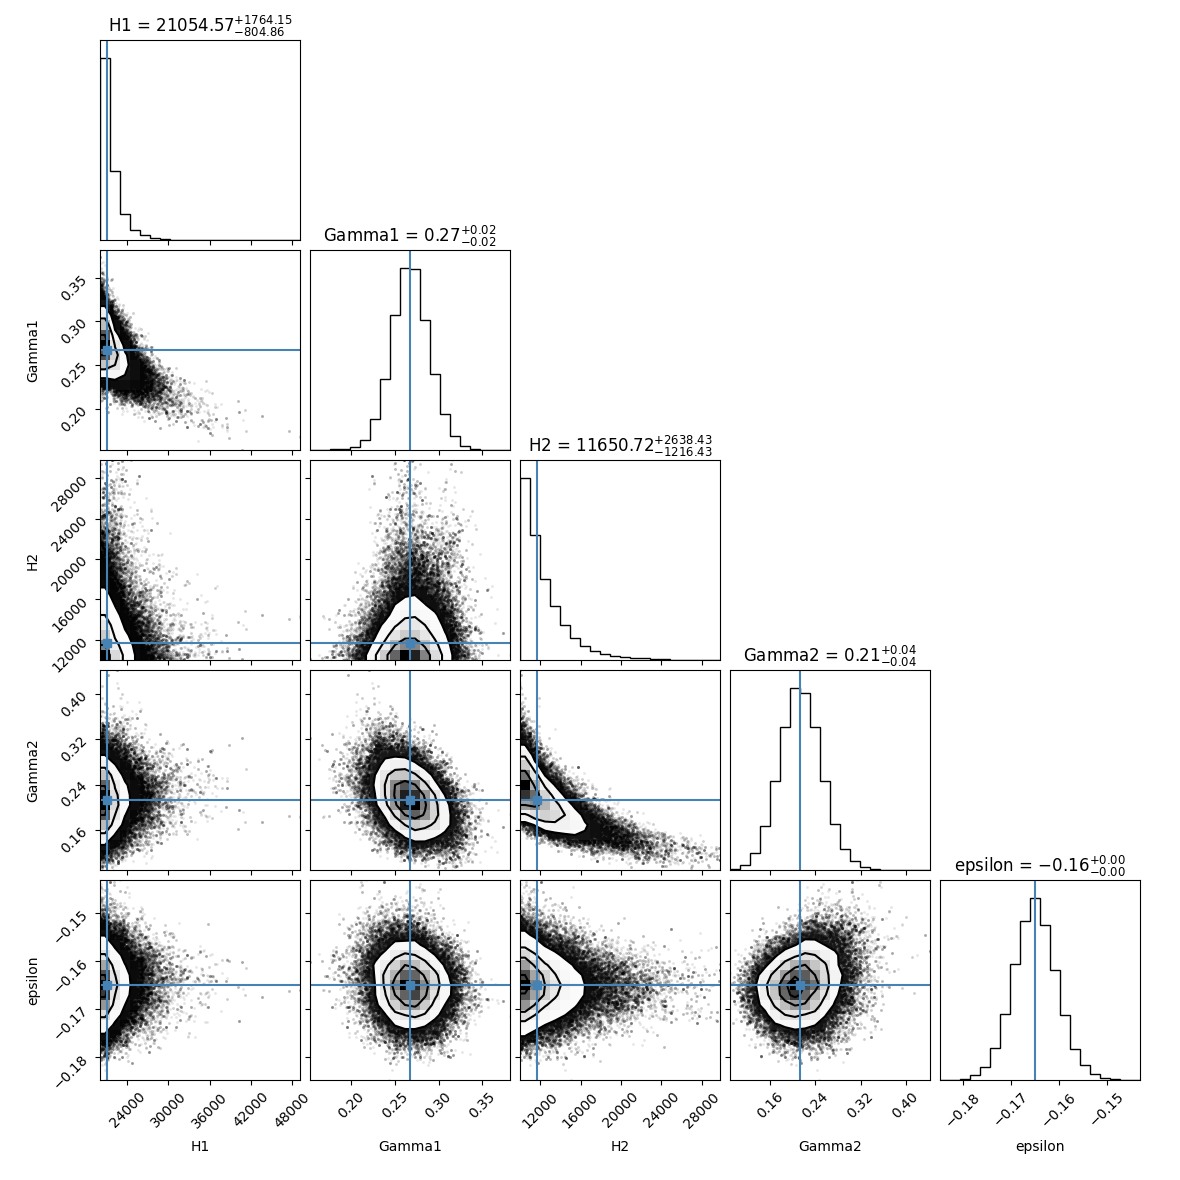

In [15]:
# fig = corner.corner(samples, labels=["H1", "nu_center1", "Gamma1", "H2", "nu_center2", "Gamma2"], truths=best_params, show_titles=True)
# fig = corner.corner(samples, labels=["H1", "Gamma1", "H2", "Gamma2", "Delta_nu", "epsilon", "alpha"], truths=best_params, show_titles=True)
fig = corner.corner(samples, labels=["H1", "Gamma1", "H2", "Gamma2", "epsilon", "d02"], truths=best_params, show_titles=True)

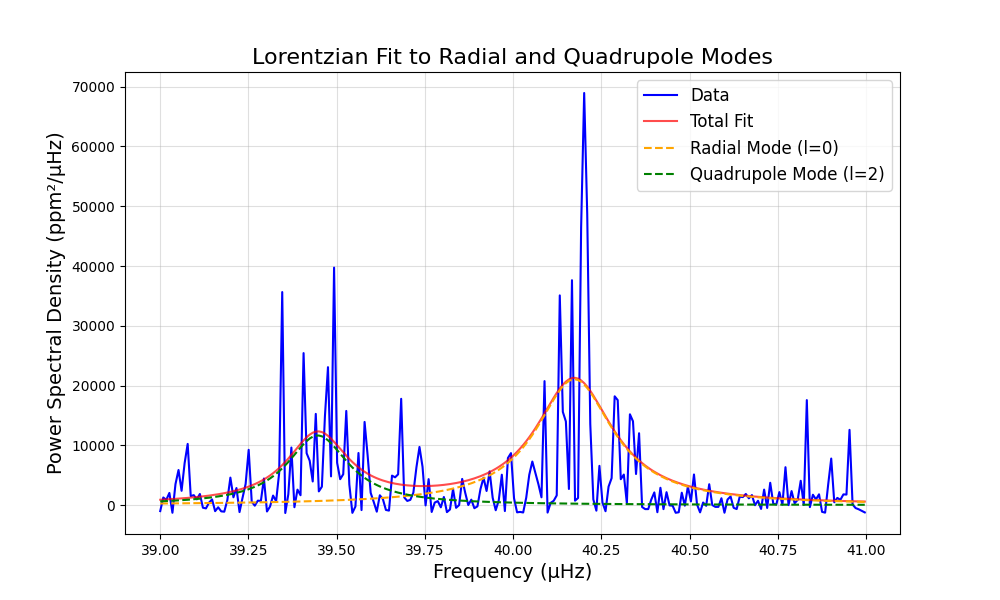

In [16]:
# # Generate the model
# model_fit = lorentzian_sum(frequency_peak, H1, nu_center1, Gamma1, H2, nu_center2, Gamma2)
# radial_fit = lorentzian(frequency_peak, H1, nu_center1, Gamma1)
# quadrupole_fit = lorentzian(frequency_peak, H2, nu_center2, Gamma2)

# # Plot
# plt.figure(figsize=(10, 6))
# plt.plot(frequency_peak, power_density_peak, label="Data", color="blue")
# plt.plot(frequency_peak, model_fit, label="Total Fit", color="red")
# plt.plot(frequency_peak, radial_fit, linestyle="--", label="Radial Mode (l=0)", color="orange")
# plt.plot(frequency_peak, quadrupole_fit, linestyle="--", label="Quadrupole Mode (l=2)", color="green")
# plt.xlabel("Frequency (µHz)")
# plt.ylabel("Power Spectral Density (ppm²/µHz)")
# plt.legend()
# plt.title("Lorentzian Fit to Radial and Quadrupole Modes")
# plt.grid()
# plt.show()

# # Generate the model using the full asymptotic formula
# model_fit = lorentzian_sum(frequency_peak, H1, Gamma1, H2, Gamma2, Delta_nu, epsilon, alpha)
# radial_fit = lorentzian(frequency_peak, H1, nu_center1, Gamma1)
# quadrupole_fit = lorentzian(frequency_peak, H2, nu_center2, Gamma2) 

# # Plot the data and fits
# plt.figure(figsize=(10, 6))
# plt.plot(frequency_peak, power_density_peak, label="Data", color="blue", linewidth=1.5)
# plt.plot(frequency_peak, model_fit, label="Total Fit", color="red", linewidth=1.5, alpha=0.7)
# plt.plot(frequency_peak, radial_fit, linestyle="--", label="Radial Mode (l=0)", color="orange", linewidth=1.5)
# plt.plot(frequency_peak, quadrupole_fit, linestyle="--", label="Quadrupole Mode (l=2)", color="green", linewidth=1.5)

# # Add labels, legend, and grid
# plt.xlabel("Frequency (µHz)", fontsize=14)
# plt.ylabel("Power Spectral Density (ppm²/µHz)", fontsize=14)
# plt.legend(fontsize=12)
# plt.title("Lorentzian Fit to Radial and Quadrupole Modes", fontsize=16)
# plt.grid(alpha=0.4)

# # Show the plot
# plt.show()

# Generate the model using the full asymptotic formula
model_fit = lorentzian_sum(frequency_peak, H1, Gamma1, H2, Gamma2, d02)
radial_fit = lorentzian(frequency_peak, H1, nu_center1, Gamma1)
quadrupole_fit = lorentzian(frequency_peak, H2, nu_center2, Gamma2)

# Plot the data and fits
plt.figure(figsize=(10, 6))
plt.plot(frequency_peak, power_density_peak, label="Data", color="blue", linewidth=1.5)
plt.plot(frequency_peak, model_fit, label="Total Fit", color="red", linewidth=1.5, alpha=0.7)
plt.plot(frequency_peak, radial_fit, linestyle="--", label="Radial Mode (l=0)", color="orange", linewidth=1.5)
plt.plot(frequency_peak, quadrupole_fit, linestyle="--", label="Quadrupole Mode (l=2)", color="green", linewidth=1.5)

# Add labels, legend, and grid
plt.xlabel("Frequency (µHz)", fontsize=14)
plt.ylabel("Power Spectral Density (ppm²/µHz)", fontsize=14)
plt.legend(fontsize=12)
plt.title("Lorentzian Fit to Radial and Quadrupole Modes", fontsize=16)
plt.grid(alpha=0.4)

(0.0, 100000.0)

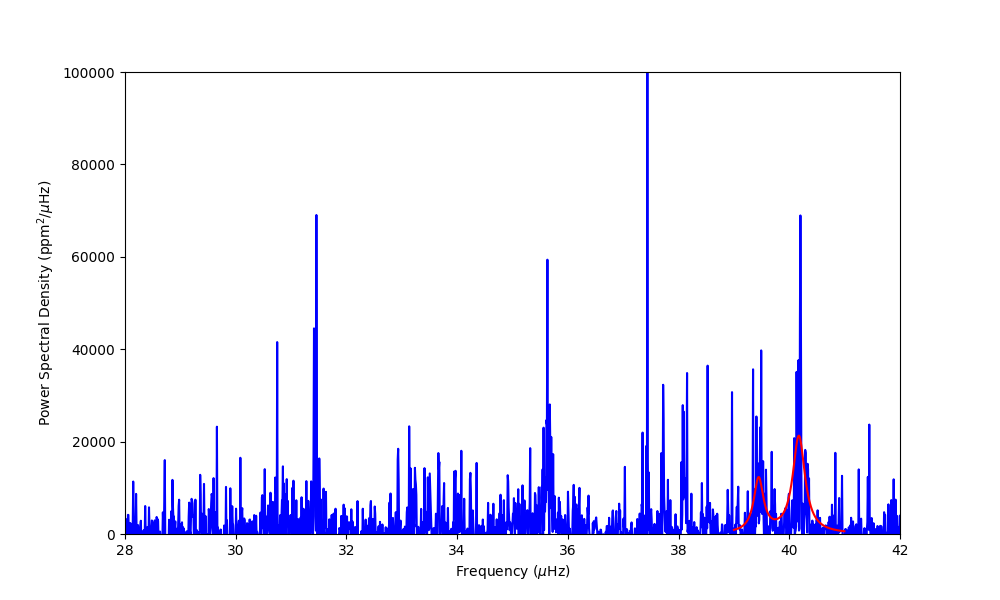

In [17]:
# plot the entire data with the peak and the fitted model
plt.figure(figsize=(10, 6))
plt.plot(f_cut, required_psd, label="Power Spectrum before background subtraction", color="blue")
plt.plot(frequency_peak, model_fit, label="Total Fit", color="red")
# plt.plot(frequency_peak, radial_fit, linestyle="--", label="Radial Mode (l=0)", color="orange")
# plt.plot(frequency_peak, quadrupole_fit, linestyle="--", label="Quadrupole Mode (l=2)", color="green")
plt.xlabel("Frequency ($\mu$Hz)")
plt.ylabel("Power Spectral Density (ppm$^2/\mu$Hz)")
plt.xlim(28, 42)
plt.ylim(0, 1e5)

In [18]:
alpha = 0.0098

def lorentzian(frequency, H, nu_center, Gamma):
    """Single Lorentzian function."""
    return H / (1 + 4 * ((frequency - nu_center) / Gamma)**2)

def lorentzian_sum(frequency, heights_l0, heights_l2, gammas_l0, gammas_l2, epsilon, d02, Delta_nu):
    """
    Summation over specific radial orders n = 6 and n = 7 for l=0 and l=2 modes.
    Each radial order now has its own height and Gamma (linewidth).
    """
    n_radial_values = [6, 7]  # Only n=6 and n=7
    n_max = numax / Delta_nu - epsilon
    total_model = 0

    for i, n in enumerate(n_radial_values):
        # Frequency centers for l=0 and l=2
        nu_center_l0 = ((n + 1 + epsilon + alpha / 2 * (n + 1 - n_max)**2) * Delta_nu)  # l=0
        nu_center_l2 = ((n + 2 / 2 + epsilon + d02 + alpha / 2 * (n - n_max)**2) * Delta_nu)  # l=2

        # Add Lorentzians with n-dependent heights and Gamma
        total_model += lorentzian(frequency, heights_l0[i], nu_center_l0, gammas_l0[i])  # l=0
        total_model += lorentzian(frequency, heights_l2[i], nu_center_l2, gammas_l2[i])  # l=2

    return total_model

def log_likelihood(theta, frequency, power_density):
    epsilon, d02, Delta_nu = theta[:3]
    heights_l0 = theta[3:5]  # Heights for l=0 (n=6,7)
    heights_l2 = theta[5:7]  # Heights for l=2 (n=6,7)
    gammas_l0 = theta[7:9]   # Gammas for l=0 (n=6,7)
    gammas_l2 = theta[9:11]  # Gammas for l=2 (n=6,7)

    model = lorentzian_sum(frequency, heights_l0, heights_l2, gammas_l0, gammas_l2, epsilon, d02, Delta_nu)
    return -np.sum(np.log(model) + power_density / model)

def log_prior(theta):
    epsilon, d02, Delta_nu = theta[:3]
    heights_l0 = theta[3:5]
    heights_l2 = theta[5:7]
    gammas_l0 = theta[7:9]
    gammas_l2 = theta[9:11]

    # Check core parameters
    if not (0.01 < epsilon < 1.0 and -1.0 < d02 < 0.0 and 3 < Delta_nu < 6):
        return -np.inf

    # Check heights
    if not (np.all(2e4 < heights_l0) and np.all(heights_l0 < 5e4) and
            np.all(1e4 < heights_l2) and np.all(heights_l2 < 3e4)):
        return -np.inf

    # Check Gammas
    if not (np.all(0.01 < gammas_l0) and np.all(gammas_l0 < 1) and
            np.all(0.01 < gammas_l2) and np.all(gammas_l2 < 1)):
        return -np.inf

    return 0.0

def log_probability(theta, frequency, power_density):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, frequency, power_density)

# Subset data around the peak
frequency_peak = f[((f > 34.5) & (f < 36)) | ((f > 39) & (f < 41))]
power_density_peak = required_psd[((f_cut > 34.5) & (f_cut < 36)) | ((f_cut > 39) & (f_cut < 41))]
# print(frequency_peak, power_density_peak)

# Number of radial orders
n_radial = 7

# Initial guesses
epsilon_init = 0.9
d02_init = -0.1
Delta_nu_init = 4.5
heights_l0_init = np.ones(2) * 4e4  # Heights for l=0 (n=6,7)
heights_l2_init = np.ones(2) * 2e4  # Heights for l=2 (n=6,7)
gammas_l0_init = np.ones(2) * 0.25  # Gammas for l=0 (n=6,7)
gammas_l2_init = np.ones(2) * 0.25  # Gammas for l=2 (n=6,7)

initial_guess = np.concatenate([
    [epsilon_init, d02_init, Delta_nu_init],
    heights_l0_init,
    heights_l2_init,
    gammas_l0_init,
    gammas_l2_init
])

ndim = len(initial_guess)
nwalkers = 50

# Initialize walkers around the initial guess
np.random.seed(42)
pos = initial_guess + 1e-2 * np.random.randn(nwalkers, ndim) * initial_guess

# Set up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(frequency_peak, power_density_peak))

# Run the MCMC
nburn = 5000
nprod = 5000
sampler.run_mcmc(pos, nburn + nprod, progress=True)
samples = sampler.get_chain(discard=nburn, flat=True)

# Extract best-fit parameters
best_params = np.median(samples, axis=0)
epsilon, d02, Delta_nu = best_params[:3]
heights_l0 = best_params[3:5]
heights_l2 = best_params[5:7]
gammas_l0 = best_params[7:9]
gammas_l2 = best_params[9:11]

print(f"epsilon: {epsilon:.2f}, d02: {d02:.2f}, Delta_nu: {Delta_nu:.2f}")
print(f"Heights l=0: {heights_l0}, Gammas l=0: {gammas_l0}")
print(f"Heights l=2: {heights_l2}, Gammas l=2: {gammas_l2}")

100%|██████████| 10000/10000 [00:14<00:00, 671.38it/s]

epsilon: 0.80, d02: -0.16, Delta_nu: 4.57
Heights l=0: [23799.22568775 21185.48383419], Gammas l=0: [0.14117425 0.25357427]
Heights l=2: [10696.58486947 11426.62327426], Gammas l=2: [0.16784032 0.2354711 ]


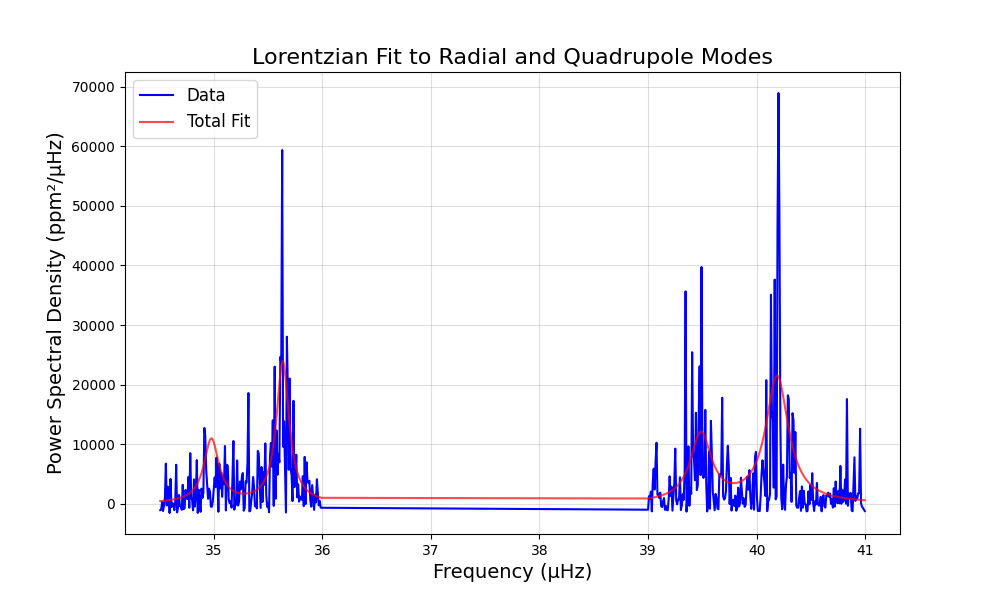

In [19]:
# Plot the lorentzian over the data
model_fit = lorentzian_sum(frequency_peak, heights_l0, heights_l2, gammas_l0, gammas_l2, epsilon, d02, Delta_nu)

# Plot the data and fits
plt.figure(figsize=(10, 6))
plt.plot(frequency_peak, power_density_peak, label="Data", color="blue", linewidth=1.5)
plt.plot(frequency_peak, model_fit, label="Total Fit", color="red", linewidth=1.5, alpha=0.7)
plt.xlabel("Frequency (µHz)", fontsize=14)
plt.ylabel("Power Spectral Density (ppm²/µHz)", fontsize=14)
plt.legend(fontsize=12)
plt.title("Lorentzian Fit to Radial and Quadrupole Modes", fontsize=16)
plt.grid(alpha=0.4)
plt.show()


(0.0, 100000.0)

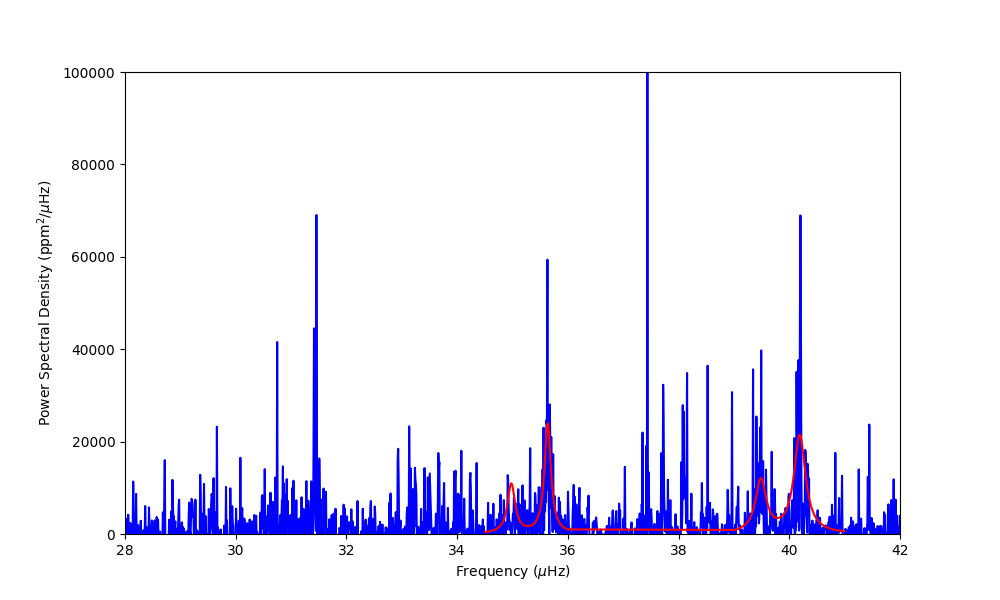

In [20]:
# plot the entire data with the peak and the fitted model
plt.figure(figsize=(10, 6))
plt.plot(f_cut, required_psd, label="Power Spectrum before background subtraction", color="blue")
plt.plot(frequency_peak, model_fit, label="Total Fit", color="red")
# plt.plot(frequency_peak, radial_fit, linestyle="--", label="Radial Mode (l=0)", color="orange")
# plt.plot(frequency_peak, quadrupole_fit, linestyle="--", label="Quadrupole Mode (l=2)", color="green")
plt.xlabel("Frequency ($\mu$Hz)")
plt.ylabel("Power Spectral Density (ppm$^2/\mu$Hz)")
plt.xlim(28, 42)
plt.ylim(0, 1e5)

In [23]:
# alpha = 0.0098
numax = 37.38
def lorentzian(frequency, H, nu_center, Gamma):
    """Single Lorentzian function."""
    return H / (1 + 4 * ((frequency - nu_center) / Gamma)**2)

def lorentzian_sum(frequency, heights_l0, heights_l2, gammas_l0, gammas_l2, epsilon, d02, Delta_nu, alpha):
    """
    Summation over specific radial orders n = 6 and n = 7 for l=0 and l=2 modes.
    Each radial order now has its own height and Gamma (linewidth).
    """
    n_radial_values = [5, 6, 7]  # Only n=6 and n=7
    n_max = numax / Delta_nu - epsilon
    total_model = 0

    for i, n in enumerate(n_radial_values):
        # Frequency centers for l=0 and l=2
        nu_center_l0 = ((n + 1 + epsilon + alpha / 2 * (n + 1 - n_max)**2) * Delta_nu)  # l=0
        nu_center_l2 = ((n + 2 / 2 + epsilon + d02 + alpha / 2 * (n - n_max)**2) * Delta_nu)  # l=2

        # Add Lorentzians with n-dependent heights and Gamma
        total_model += lorentzian(frequency, heights_l0[i], nu_center_l0, gammas_l0[i])  # l=0
        total_model += lorentzian(frequency, heights_l2[i], nu_center_l2, gammas_l2[i])  # l=2

    return total_model

def log_likelihood(theta, frequency, power_density):
    epsilon, d02, Delta_nu, alpha = theta[:4]
    heights_l0 = theta[4:7]  # Heights for l=0 (n=6,7)
    heights_l2 = theta[7:10]  # Heights for l=2 (n=6,7)
    gammas_l0 = theta[10:13]   # Gammas for l=0 (n=6,7)
    gammas_l2 = theta[13:16]  # Gammas for l=2 (n=6,7)

    model = lorentzian_sum(frequency, heights_l0, heights_l2, gammas_l0, gammas_l2, epsilon, d02, Delta_nu, alpha)
    return -np.sum(np.log(model) + power_density / model)

def log_prior(theta):
    epsilon, d02, Delta_nu, alpha = theta[:4]
    heights_l0 = theta[4:7]  # Heights for l=0 (n=6,7)
    heights_l2 = theta[7:10]  # Heights for l=2 (n=6,7)
    gammas_l0 = theta[10:13]   # Gammas for l=0 (n=6,7)
    gammas_l2 = theta[13:16]  # Gammas for l=2 (n=6,7)

    # Check core parameters
    if not (0.01 < epsilon < 1.0 and -1.0 < d02 < 0.0 and 3 < Delta_nu < 6 and 0 < alpha < 0.1):
        return -np.inf

    # Check heights
    if not (np.all(2e4 < heights_l0) and np.all(heights_l0 < 1e5) and
            np.all(1e3 < heights_l2) and np.all(heights_l2 < 3e4)):
        return -np.inf

    # Check Gammas
    if not (np.all(0.05 < gammas_l0) and np.all(gammas_l0 < 1) and
            np.all(0.05 < gammas_l2) and np.all(gammas_l2 < 1)):
        return -np.inf

    return 0.0

def log_probability(theta, frequency, power_density):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, frequency, power_density)

# Subset data around the peak
frequency_peak = f[((f > 30.5) & (f < 32)) | ((f > 34.5) & (f < 36)) | ((f > 39) & (f < 40.5))]
power_density_peak = required_psd[((f_cut > 30.5) & (f_cut < 32)) | ((f_cut > 34.5) & (f_cut < 36)) | ((f_cut > 39) & (f_cut < 40.5))]
# print(frequency_peak, power_density_peak)

# Initial guesses
epsilon_init = 0.9
d02_init = -0.1
alpha_init = 0.01
Delta_nu_init = 4.5
heights_l0_init = np.ones(3) * 4e4  # Heights for l=0 (n=6,7)
heights_l2_init = np.ones(3) * 2e4  # Heights for l=2 (n=6,7)
gammas_l0_init = np.ones(3) * 0.25  # Gammas for l=0 (n=6,7)
gammas_l2_init = np.ones(3) * 0.3  # Gammas for l=2 (n=6,7)

initial_guess = np.concatenate([
    [epsilon_init, d02_init, Delta_nu_init, alpha_init],
    heights_l0_init,
    heights_l2_init,
    gammas_l0_init,
    gammas_l2_init
])

ndim = len(initial_guess)
nwalkers = 50

# Initialize walkers around the initial guess
np.random.seed(42)
pos = initial_guess + 1e-2 * np.random.randn(nwalkers, ndim) * initial_guess

# Set up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(frequency_peak, power_density_peak))

# Run the MCMC
nburn = 10000
nprod = 5000
sampler.run_mcmc(pos, nburn + nprod, progress=True)
samples = sampler.get_chain(discard=nburn+3000, flat=True)

# Extract best-fit parameters
best_params = np.median(samples, axis=0)
epsilon, d02, Delta_nu, alpha = best_params[:4]
heights_l0 = best_params[4:7]
heights_l2 = best_params[7:10]
gammas_l0 = best_params[10:13]
gammas_l2 = best_params[13:16]

print(f"epsilon: {epsilon:.2f}, d02: {d02:.2f}, Delta_nu: {Delta_nu:.2f}, Alpha: {alpha:.2f}")
print(f"Heights l=0: {heights_l0}, Gammas l=0: {gammas_l0}")
print(f"Heights l=2: {heights_l2}, Gammas l=2: {gammas_l2}")

100%|██████████| 15000/15000 [01:09<00:00, 216.86it/s]


epsilon: 0.96, d02: -0.16, Delta_nu: 4.48, Alpha: 0.05
Heights l=0: [25813.58448223 27189.19133401 33168.236578  ], Gammas l=0: [0.05825489 0.10188577 0.10285646]
Heights l=2: [4051.82556705 3823.53507817 9191.76647572], Gammas l=2: [0.9346792  0.58242332 0.34186475]


(0.0, 100000.0)

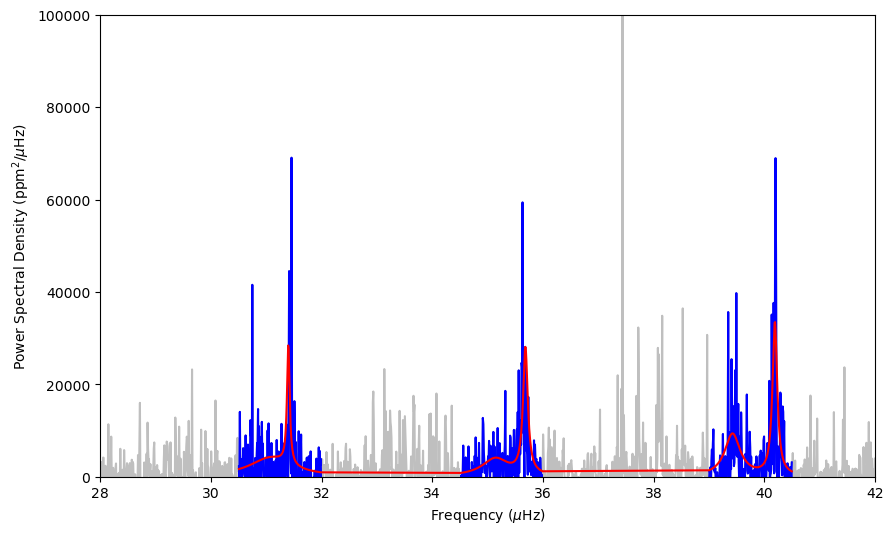

In [25]:
model_fit = lorentzian_sum(frequency_peak, heights_l0, heights_l2, gammas_l0, gammas_l2, epsilon, d02, Delta_nu, alpha)

# plot the entire data with the peak and the fitted model
plt.figure(figsize=(10, 6))
plt.plot(f_cut, required_psd, label="Power Spectrum before background subtraction", color="grey", alpha = 0.5)

plt.plot(frequency_peak, power_density_peak, label="Data", color="blue")
plt.plot(frequency_peak, model_fit, label="Total Fit", color="red")
# plt.plot(frequency_peak, radial_fit, linestyle="--", label="Radial Mode (l=0)", color="orange")
# plt.plot(frequency_peak, quadrupole_fit, linestyle="--", label="Quadrupole Mode (l=2)", color="green")
plt.xlabel("Frequency ($\mu$Hz)")
plt.ylabel("Power Spectral Density (ppm$^2/\mu$Hz)")
plt.xlim(28, 42)
plt.ylim(0, 1e5)

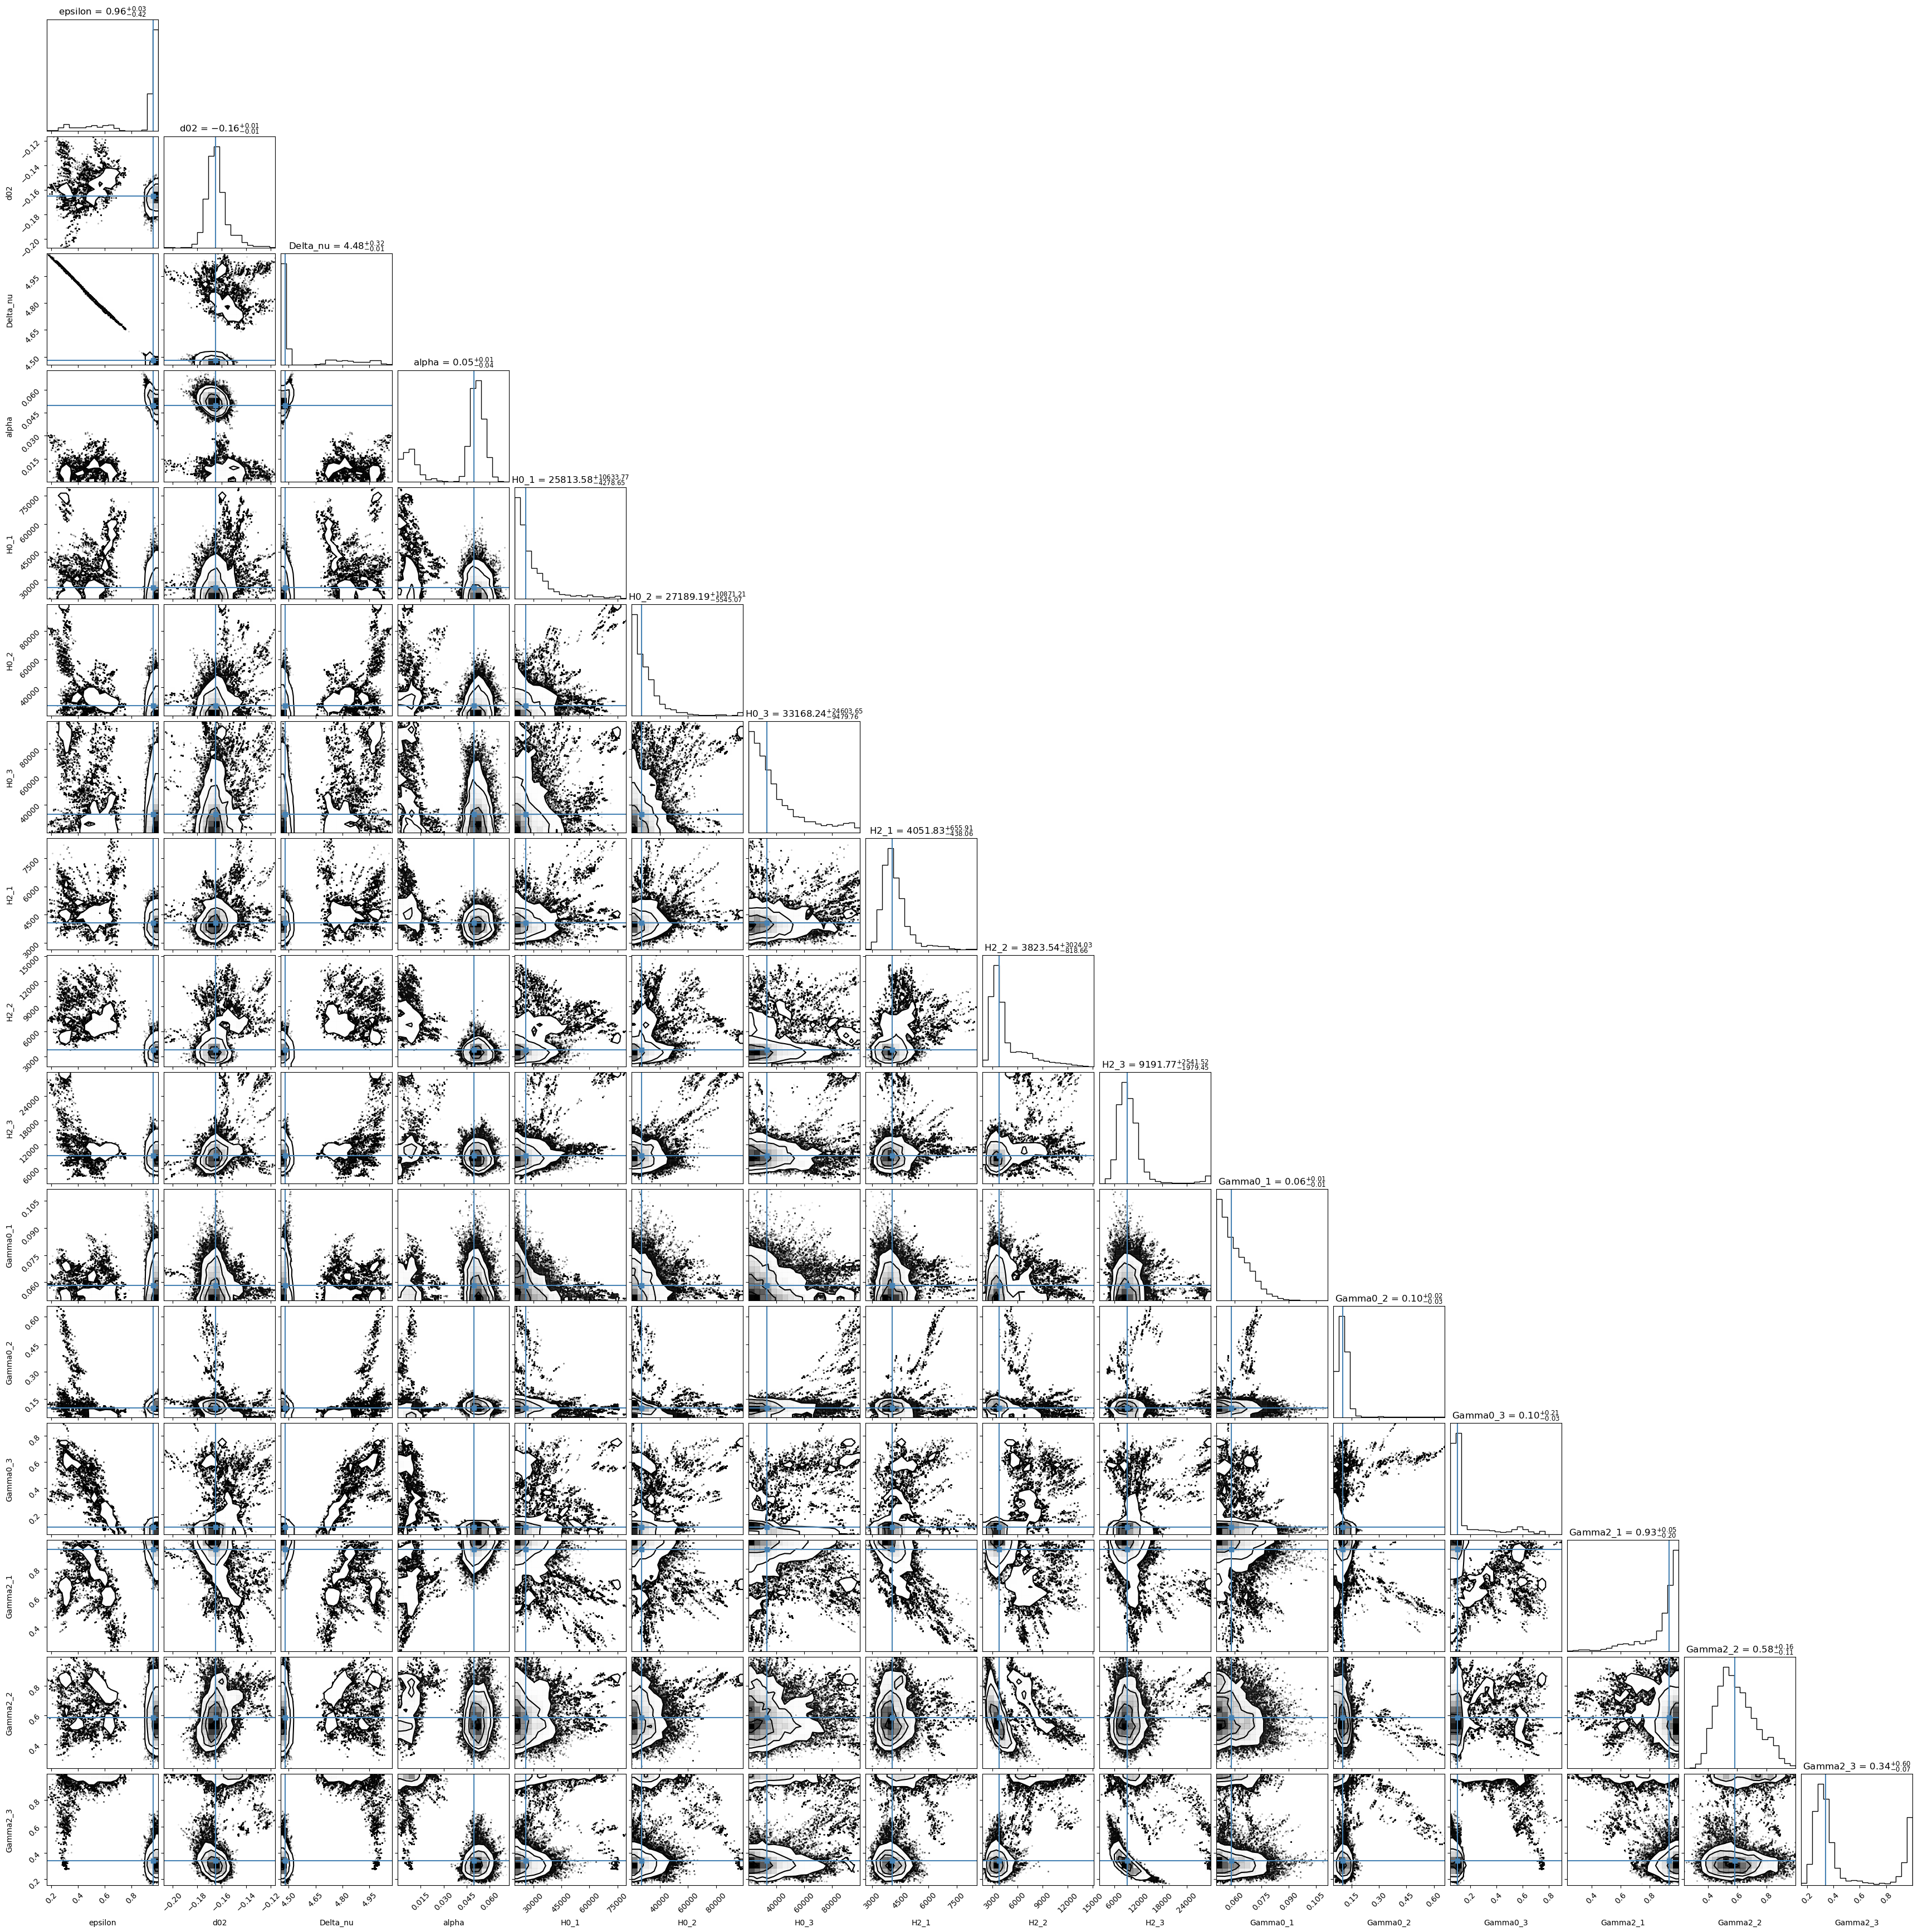

In [26]:
fig = corner.corner(samples, labels=["epsilon", "d02", "Delta_nu", "alpha", "H0_1", "H0_2", "H0_3", "H2_1", "H2_2", "H2_3", "Gamma0_1", "Gamma0_2", "Gamma0_3", "Gamma2_1", "Gamma2_2", "Gamma2_3"], truths=best_params, show_titles=True)
fig.savefig("corner_plot.png")